### Libraries

In [8]:
import os
import numpy as np
import tensorflow as tf
#from tensorflow.keras import mixed_precision
#from tensorflow.keras.optimizers import AdamW
from tensorflow_addons.optimizers import AdamW
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.animation import FuncAnimation 
from mpl_toolkits.mplot3d import Axes3D
import time
import copy
import datetime


### Config

In [46]:
time_stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
from_scratch=False # True: start fresh, False: resume from checkpoint

# Model paths
SAVE_Full_MODEL_PATH = f"/Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_RNN_autoregressive_2head_{time_stamp}.keras" # saving full model checkpoint if from scratch=True
LOAD_MODEL_PATH = "/Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_RNN_autoregressive_2head_20251127-215757.keras"  # path to load model checkpoint from if from_scratch=False

# TensorBoard directory

log_dir = f"/Users/akhidre/pubgit/CS230_T2motion/fit/{time_stamp}/"

#define data destination
TRAIN_NPZ = "/Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion.npz"
TEST_NPZ  = "/Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion_val.npz"
NORM_STATS = "motion_norm_stats.npz"   # if exists, used; otherwise computed from train npz

MOTION_LEN = 200         # fixed length for MLP outputs (frames)
NUM_JOINTS = 22
COORDS = 3
OUTPUT_DIM = MOTION_LEN * NUM_JOINTS * COORDS

MAX_TRAIN_SAMPLES =0    # 0 = use all; otherwise use first N pairs
MAX_TEST_SAMPLES = 0   # 0 = use all; otherwise use first N pairs

USE_NORMALIZATION = True  #normalize data to zero mean and unity variance

# Training Monitoring and Callbacks
USE_GPU = False
USE_LR_SCHEDULER = False
USE_EARLY_STOPPING = True
USE_LR_LOGGER = False # only if you added the logger

# Training hyperparams
BATCH_SIZE = 1024
EPOCHS = 70
LEARNING_RATE = 1e-4
HIDDEN_DIMS = [256,256]  # list: MLPor RNN layers depths
RNN_CELL    = "LSTM" # "LSTM" or "GRU"
# Loss options
USE_VELOCITY_LOSS = True
LAMBDA_VEL = 1 # weight for velocity loss vs pose loss (tune if needed)
LAMBDA_ROOT = 20.0  # weight for root-velocity loss vs pose loss (tune if needed)
WEIGHT_DECAY = 1e-4 # weight decay for AdamW optimizer 

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Utilities Functions
    -loading data form npz files 
    -filter data that has less than 2 frames
    -pad or truncate motion clips to fixed length
    -extract pose and root velocities of each motion clip
    -compute stats of pose and root velocity
    -prepare LSTM/GRU decoder autoregressive inputs 


In [32]:
def load_npz_pairs(npz_path, max_samples=0):
    data = np.load(npz_path, allow_pickle=True)
    z_texts = data["z_texts"]   # shape (N, 384)
    motions = data["motions"]   # dtype=object, each entry (T, J, 3)
    motion_ids = data["motion_ids"] if "motion_ids" in data.files else None

    if max_samples and max_samples > 0:
        z_texts = z_texts[:max_samples]
        motions = motions[:max_samples]
        if motion_ids is not None:
            motion_ids = motion_ids[:max_samples]

    return z_texts, motions, motion_ids

def filter_valid_motions(z_list, motions_list, ids_list=None,
                         num_joints=22, coords=3):
    """
    Filters out invalid motion sequences that do not match (T, num_joints, coords).

    Returns:
        valid_z_list, valid_motions_list, valid_ids_list (or None if no ids)
    """
    valid_z = []
    valid_motions = []
    valid_ids = [] if ids_list is not None else None

    for idx, (z, m) in enumerate(zip(z_list, motions_list)):
        arr = np.array(m)

        # Check dimensionality
        if arr.ndim != 3:
            print(f"[Filter] Skipping sample at index={idx}, shape={arr.shape} (not 3D)")
            continue

        # Check joint and coordinate dimensions
        if arr.shape[1] != num_joints or arr.shape[2] != coords:
            print(f"[Filter] Skipping sample at index={idx}, shape={arr.shape} (bad joint dims)")
            continue

        # Keep sample
        valid_z.append(z)
        valid_motions.append(arr)

        if ids_list is not None:
            valid_ids.append(ids_list[idx])

    if ids_list is not None:
        return np.array(valid_z, dtype=np.float32), valid_motions, valid_ids
    else:
        return np.array(valid_z, dtype=np.float32), valid_motions, None

def pad_or_truncate_motion(motion, target_len=MOTION_LEN):
    """
    motion: (T, J, 3) -> returns (target_len, J, 3)
    """
    T, J, C = motion.shape
    motion = motion.astype(np.float32)
    if T == target_len:
        return motion
    if T > target_len:
        return motion[:target_len]
    # T < target_len: pad by repeating last frame
    pad_len = target_len - T
    last_frame = motion[-1][None, :, :]  # (1, J, 3)
    pad = np.repeat(last_frame, pad_len, axis=0)
    return np.concatenate([motion, pad], axis=0)


def extract_pose_and_rootvel(motion, target_len=MOTION_LEN):
    """
    motion: (T, NUM_JOINTS, 3) in absolute/world coordinates.
    Returns:
      pose_rel: (T, NUM_JOINTS, 3)  -> root-relative pose
      root_vel: (T, 3)              -> root velocity per frame
    """
    motion_fixed = pad_or_truncate_motion(motion, target_len)  # (T,J,3)

    # global root per frame = joint 0
    root = motion_fixed[:, 0, :]                               # (T,3)
    pose_rel = motion_fixed - motion_fixed[:, 0:1, :]          # (T,J,3)

    # root velocities (Δroot); v[0] = 0
    root_vel = np.zeros_like(root)
    root_vel[1:] = root[1:] - root[:-1]
    return pose_rel, root_vel


def compute_pose_rootvel_stats(motions, target_len=MOTION_LEN, save_path=None):
    """
    Compute mean/std for:
      - root-relative pose (per coord)
      - root velocities (per coord)

    motions: list of (T, J, 3) arrays (TRAIN set)
    Returns:
      pose_mean:     (1,1,1,3)
      pose_std:      (1,1,1,3)
      rootvel_mean:  (1,1,3)
      rootvel_std:   (1,1,3)
    """
    pose_coords = []
    rootvel_coords = []

    for m in motions:
        pose_rel, root_vel = extract_pose_and_rootvel(m, target_len)
        pose_coords.append(pose_rel.reshape(-1, COORDS))    # (T*J,3)
        rootvel_coords.append(root_vel.reshape(-1, COORDS)) # (T,3)

    pose_coords = np.concatenate(pose_coords, axis=0)
    rootvel_coords = np.concatenate(rootvel_coords, axis=0)

    pose_mean = pose_coords.mean(axis=0, keepdims=True)         # (1,3)
    pose_std  = pose_coords.std(axis=0, keepdims=True) + 1e-8
    rootvel_mean = rootvel_coords.mean(axis=0, keepdims=True)   # (1,3)
    rootvel_std  = rootvel_coords.std(axis=0, keepdims=True) + 1e-8

    # reshape for broadcasting
    pose_mean    = pose_mean.reshape(1, 1, 1, 3).astype(np.float32)
    pose_std     = pose_std.reshape(1, 1, 1, 3).astype(np.float32)
    rootvel_mean = rootvel_mean.reshape(1, 1, 3).astype(np.float32)
    rootvel_std  = rootvel_std.reshape(1, 1, 3).astype(np.float32)

    if save_path is not None:
        np.savez(
            save_path,
            pose_mean=pose_mean,
            pose_std=pose_std,
            rootvel_mean=rootvel_mean,
            rootvel_std=rootvel_std,
        )
        print(f"Saved pose/rootvel normalization stats to {save_path}")

    return pose_mean, pose_std, rootvel_mean, rootvel_std

def build_decoder_inputs(Y_pose, Y_root):
    """
    Build teacher-forcing decoder inputs for autoregressive training.

    Y_pose: (N, T, J, 3)  ground-truth pose sequence
    Y_root: (N, T, 3)     ground-truth root velocity sequence

    Returns:
        dec_in: (N, T, J*3 + 3)
        where:
            dec_in[:, 0, :]       = 0
            dec_in[:, t, :J*3]    = pose_true[:, t-1]  (flattened)
            dec_in[:, t, J*3:]    = root_true[:, t-1]
    """
    N, T, J, C = Y_pose.shape  # C should be 3
    pose_flat = Y_pose.reshape(N, T, J * C)   # (N, T, J*3)

    dec_in = np.zeros((N, T, J * C + C), dtype=np.float32)

    # For t >= 1, use ground truth from previous step
    dec_in[:, 1:, :J*C] = pose_flat[:, :-1, :]
    dec_in[:, 1:, J*C:] = Y_root[:, :-1, :]

    return dec_in

def generate_motion_autoregressive(
    model,
    z_text,
    motion_len,
    num_joints,
    coords,
    verbose=False
):
    """
    Autoregressive sampling WITHOUT teacher forcing.

    Args:
        model      : trained Keras model with inputs [z_text, decoder_input]
                     and outputs [pose_out, rootvel_out].
        z_text     : (B, Z_DIM) text embeddings.
        motion_len : int, number of frames T to generate.
        num_joints : int, J.
        coords     : int, usually 3.
        verbose    : if True, prints occasional progress.

    Returns:
        pose_pred_all : (B, T, J, C)  (STILL IN THE SAME SPACE AS TRAINING,
                                       i.e. normalized if USE_NORMALIZATION=True)
        root_pred_all : (B, T, C)
    """
    z_text = np.asarray(z_text, dtype=np.float32)
    batch_size = z_text.shape[0]

    feat_dim = num_joints * coords + coords  # pose(J*3) + rootvel(3)

    # Decoder input we will fill step by step
    decoder_input = np.zeros((batch_size, motion_len, feat_dim),
                             dtype=np.float32)

    pose_pred_all = np.zeros((batch_size, motion_len, num_joints, coords),
                             dtype=np.float32)
    root_pred_all = np.zeros((batch_size, motion_len, coords),
                             dtype=np.float32)

    for t in range(motion_len):
        if verbose and (t % 20 == 0 or t == motion_len - 1):
            print(f"Autoreg step {t+1}/{motion_len}")

        # Run model on current decoder_input
        pose_pred, root_pred = model.predict(
            [z_text, decoder_input],
            verbose=0
        )  # pose_pred: (B,T,J,C), root_pred: (B,T,C)

        # Take only the current frame t
        pose_t = pose_pred[:, t, :, :]   # (B,J,C)
        root_t = root_pred[:, t, :]      # (B,C)

        pose_pred_all[:, t, :, :] = pose_t
        root_pred_all[:, t, :]    = root_t

        # Prepare decoder input for next time step (t+1)
        if t < motion_len - 1:
            pose_flat_t = pose_t.reshape(batch_size, num_joints * coords)
            decoder_input[:, t+1, :num_joints * coords] = pose_flat_t
            decoder_input[:, t+1, num_joints * coords:] = root_t

    return pose_pred_all, root_pred_all



### Load data 

In [33]:
print("Loading train npz:", TRAIN_NPZ)
z_train, motions_train, ids_train = load_npz_pairs(TRAIN_NPZ, max_samples=MAX_TRAIN_SAMPLES)
print("Filtering training motions...")
z_train, motions_train, ids_train = filter_valid_motions(z_train, motions_train, ids_train)
print("Final train samples:", len(z_train))

print("Loading test npz:", TEST_NPZ)
z_test, motions_test, ids_test = load_npz_pairs(TEST_NPZ, max_samples=MAX_TEST_SAMPLES)

print("Filtering test motions...")
z_test, motions_test, ids_test = filter_valid_motions(z_test, motions_test, ids_test)
print("Final test samples:", len(z_test))


print("Train captions:", z_train.shape)
print("Train motions count:", len(motions_train))
print("Train ids_count:", len(ids_train))
print("Test captions:", z_test.shape)
print("Test motions count:", len(motions_test))
print("Test ids_count:", len(ids_test))

Loading train npz: /Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion.npz
Filtering training motions...
[Filter] Skipping sample at index=2384, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=2385, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=2386, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14019, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14020, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14021, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37332, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37333, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37334, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48967, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48968, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48969, shape=(22, 3) (not 3D)
Final train samples: 69884
Loading test npz: /Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion_val.npz
Filteri

### Compute data statistics

In [34]:
if os.path.exists(NORM_STATS):
    stats = np.load(NORM_STATS)
    pose_mean     = stats["pose_mean"]
    pose_std      = stats["pose_std"]
    rootvel_mean  = stats["rootvel_mean"]
    rootvel_std   = stats["rootvel_std"]
    print("Loaded normalization stats from", NORM_STATS)
else:
    print("Computing normalization stats (root-relative pose + root velocity)...")
    pose_mean, pose_std, rootvel_mean, rootvel_std = compute_pose_rootvel_stats(
        motions_train,
        target_len=MOTION_LEN,
        save_path=None
    )

print("pose_mean:", pose_mean, "pose_std:", pose_std)
print("rootvel_mean:", rootvel_mean, "rootvel_std:", rootvel_std)


Computing normalization stats (root-relative pose + root velocity)...
pose_mean: [[[[-0.00023493 -0.02042538  0.01167196]]]] pose_std: [[[[0.1076361  0.23476106 0.1065274 ]]]]
rootvel_mean: [[[ 3.9163851e-06 -8.9967598e-06  2.7644455e-03]]] rootvel_std: [[[0.01206515 0.0096471  0.01815101]]]


### Prepare dataset

In [35]:
def prepare_xy_multi(z_list,
                     motions_objectlist,
                     pose_mean, pose_std,
                     rootvel_mean, rootvel_std,
                     motion_len=MOTION_LEN,use_normalization=USE_NORMALIZATION):
    """
    Returns:
      X:       (N, 384)
      Y_pose:  (N, T, J, 3)   normalized root-relative pose
      Y_root:  (N, T, 3)      normalized root velocities
    """
    N = len(z_list)
    X = np.array(z_list, dtype=np.float32)  # (N, 384)

    Y_pose = np.zeros((N, motion_len, NUM_JOINTS, COORDS), dtype=np.float32)
    Y_root = np.zeros((N, motion_len, COORDS), dtype=np.float32)

    for i, m in enumerate(motions_objectlist):
        pose_rel, root_vel = extract_pose_and_rootvel(m, target_len=motion_len)

        pose_norm    = (pose_rel - pose_mean) / pose_std
        rootvel_norm = (root_vel - rootvel_mean) / rootvel_std
        if use_normalization:
            Y_pose[i] = pose_norm
            Y_root[i] = rootvel_norm
        else:
            Y_pose[i] = pose_rel
            Y_root[i] = root_vel

    return X, Y_pose, Y_root

print("Preparing training tensors...")
X_train, Y_pose_train, Y_root_train = prepare_xy_multi(
    z_train, motions_train,
    pose_mean, pose_std,
    rootvel_mean, rootvel_std,
    motion_len=MOTION_LEN,
    use_normalization=USE_NORMALIZATION
)

print("Preparing test tensors...")
X_test, Y_pose_test, Y_root_test = prepare_xy_multi(
    z_test, motions_test,
    pose_mean, pose_std,
    rootvel_mean, rootvel_std,
    motion_len=MOTION_LEN,
    use_normalization=USE_NORMALIZATION
)
decoder_input_train = build_decoder_inputs(Y_pose_train, Y_root_train)
decoder_input_test  = build_decoder_inputs(Y_pose_test,  Y_root_test)

print("Shapes:")
print("  X_train:", X_train.shape)
print("  Y_pose_train:", Y_pose_train.shape)
print("  Y_root_train:", Y_root_train.shape)
print("  X_test:", X_test.shape)
print("  Y_pose_test:", Y_pose_test.shape)
print("  Y_root_test:", Y_root_test.shape)
print("decoder_input_train:", decoder_input_train.shape)
print("decoder_input_test:",  decoder_input_test.shape)

Preparing training tensors...
Preparing test tensors...
Shapes:
  X_train: (69884, 384)
  Y_pose_train: (69884, 200, 22, 3)
  Y_root_train: (69884, 200, 3)
  X_test: (4362, 384)
  Y_pose_test: (4362, 200, 22, 3)
  Y_root_test: (4362, 200, 3)
decoder_input_train: (69884, 200, 69)
decoder_input_test: (4362, 200, 69)


### Model

In [36]:
tf.keras.backend.clear_session()  # Clear any existing session
# Optional mixed precision on GPU
if USE_GPU:
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision policy:", mixed_precision.global_policy())

# ---------------------------
# Model hyperparams
# ---------------------------
Z_DIM       = X_train.shape[1]       # 384 for all-MiniLM
# ---------------------------
# Inputs:
#   1) z_text: sentence embedding (B, 384)
#   2) decoder_input: previous pose+rootvel (B, T, J*3+3)
# ---------------------------
z_text_in = tf.keras.Input(
    shape=(Z_DIM,),
    dtype=tf.float32,
    name="z_text"
)

decoder_in = tf.keras.Input(
    shape=(MOTION_LEN, NUM_JOINTS * COORDS + COORDS),
    dtype=tf.float32,
    name="decoder_input"
)

# --------------------------------------------------------
# Build initial states for each recurrent layer from z_text
# For LSTM: we need (h0, c0) per layer
# For GRU:  we need h0 per layer
# --------------------------------------------------------
init_states = []   # list of lists, one per layer

for i, dim in enumerate(HIDDEN_DIMS):
    if RNN_CELL.upper() == "LSTM":
        h0_i = tf.keras.layers.Dense(
            dim, activation="tanh", name=f"init_h_{i}"
        )(z_text_in)
        c0_i = tf.keras.layers.Dense(
            dim, activation="tanh", name=f"init_c_{i}"
        )(z_text_in)
        init_states.append([h0_i, c0_i])
    elif RNN_CELL.upper() == "GRU":
        h0_i = tf.keras.layers.Dense(
            dim, activation="tanh", name=f"init_h_{i}"
        )(z_text_in)
        init_states.append([h0_i])
    else:
        raise ValueError(f"Unsupported RNN_CELL: {RNN_CELL}")

# --------------------------------------------------------
# Build recurrent stack (LSTM or GRU)
# --------------------------------------------------------
x = decoder_in

for i, dim in enumerate(HIDDEN_DIMS):
    is_last = (i == len(HIDDEN_DIMS) - 1)

    if RNN_CELL.upper() == "LSTM":
        rnn_layer = tf.keras.layers.LSTM(
            dim,
            return_sequences=True,
            return_state=False,
            name=f"lstm_decoder_{i}"
        )
        x = rnn_layer(
            x,
            initial_state=init_states[i]  # [h0_i, c0_i]
        )

    elif RNN_CELL.upper() == "GRU":
        rnn_layer = tf.keras.layers.GRU(
            dim,
            return_sequences=True,
            return_state=False,
            name=f"gru_decoder_{i}"
        )
        x = rnn_layer(
            x,
            initial_state=init_states[i]  # [h0_i]
        )

decoder_hidden_seq = x  # (B, T, H_last)

# --------------------------------------------------------
# Two heads:
#   1) pose_out    : (B, T, J, 3)
#   2) rootvel_out : (B, T, 3)
# --------------------------------------------------------

# Pose head: dense over time → reshape
pose_head = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(NUM_JOINTS * COORDS, activation=None),
    name="pose_dense"
)(decoder_hidden_seq)  # (B, T, J*3)

pose_out = tf.keras.layers.Reshape(
    (MOTION_LEN, NUM_JOINTS, COORDS),
    name="pose_out"
)(pose_head)

# Root-velocity head
rootvel_out = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(COORDS, activation=None),
    name="rootvel_out"
)(decoder_hidden_seq)  # (B, T, 3)


# ---------------------------
# Velocity-based loss (optional) on pose sequence
# ---------------------------
def velocity_from_pose_seq(pose_seq):
    """
    pose_seq: (B, T, J, 3)
    returns:  (B, T-1, J, 3) finite-difference velocity
    """
    return pose_seq[:, 1:, :, :] - pose_seq[:, :-1, :, :]

def pose_loss_with_vel(y_true, y_pred):
    """
    y_true, y_pred: (B, T, J, 3)
    MSE on pose + optionally MSE on velocity if USE_VELOCITY_LOSS is True.
    """
    # Pose MSE
    pose_mse = tf.reduce_mean(tf.square(y_true - y_pred))

    if USE_VELOCITY_LOSS:
        vel_true = velocity_from_pose_seq(y_true)
        vel_pred = velocity_from_pose_seq(y_pred)
        vel_mse  = tf.reduce_mean(tf.square(vel_true - vel_pred))
        return pose_mse + LAMBDA_VEL * vel_mse
    else:
        return pose_mse

# ---------------------------
# Build and compile model
# ---------------------------
model = tf.keras.Model(
    inputs=[z_text_in, decoder_in],
    outputs=[pose_out, rootvel_out],
    name="autoreg_text2motion_RNN"
)

optimizer = AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss=[pose_loss_with_vel, "mse"],      # [pose_out, rootvel_out]
    loss_weights=[1.0, LAMBDA_ROOT]
)

model.summary()


Model: "autoreg_text2motion_RNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 z_text (InputLayer)         [(None, 384)]                0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, 200, 69)]            0         []                            
                                                                                                  
 init_h_0 (Dense)            (None, 256)                  98560     ['z_text[0][0]']              
                                                                                                  
 init_c_0 (Dense)            (None, 256)                  98560     ['z_text[0][0]']              
                                                                            

### Training callbacks and monitors 

In [37]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,   # enables gradients & weights monitoring
    write_graph=False
)

# Reduce LR on Plateau
reduceLR_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Early stopping
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Save best weights only
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=SAVE_Full_MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
class LRTensorBoard(tf.keras.callbacks.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.file_writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        with self.file_writer.as_default():
            tf.summary.scalar("learning_rate", lr, step=epoch)

lr_logger = LRTensorBoard(log_dir=log_dir)





callbacks_list = [tensorboard_cb, checkpoint_cb]

if USE_LR_SCHEDULER:
    callbacks_list.append(reduceLR_cb)

if USE_EARLY_STOPPING:
    callbacks_list.append(earlystop_cb)

# Optional: add LR logger if you use it
if USE_LR_LOGGER:
    callbacks_list.append(lr_logger)

### Training

Loading model from: /Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_RNN_autoregressive_2head_20251127-215757.keras
Epoch 1/70
69/69 [==============================] - ETA: 0s - loss: 1.5297 - pose_out_loss: 0.1312 - rootvel_out_loss: 0.0699
Epoch 1: val_loss did not improve from 1.27847
69/69 [==============================] - 258s 4s/step - loss: 1.5297 - pose_out_loss: 0.1312 - rootvel_out_loss: 0.0699 - val_loss: 1.2859 - val_pose_out_loss: 0.1283 - val_rootvel_out_loss: 0.0579
Epoch 2/70
69/69 [==============================] - ETA: 0s - loss: 1.3652 - pose_out_loss: 0.1240 - rootvel_out_loss: 0.0621
Epoch 2: val_loss improved from 1.27847 to 1.22779, saving model to /Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_RNN_autoregressive_2head_20251127-215757.keras
69/69 [==============================] - 238s 3s/step - loss: 1.3652 - pose_out_loss: 0.1240 - rootvel_out_loss: 0.0621 - val_loss: 1.2278 - val_pose_out_loss: 0.1222 - val_rootvel_out_loss: 0.0553
Epo

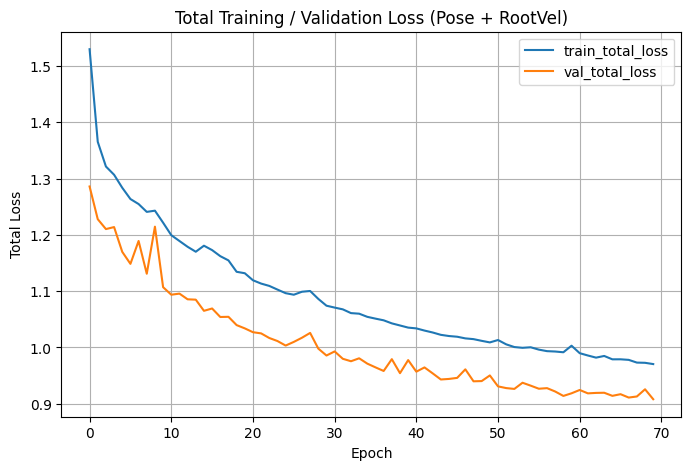

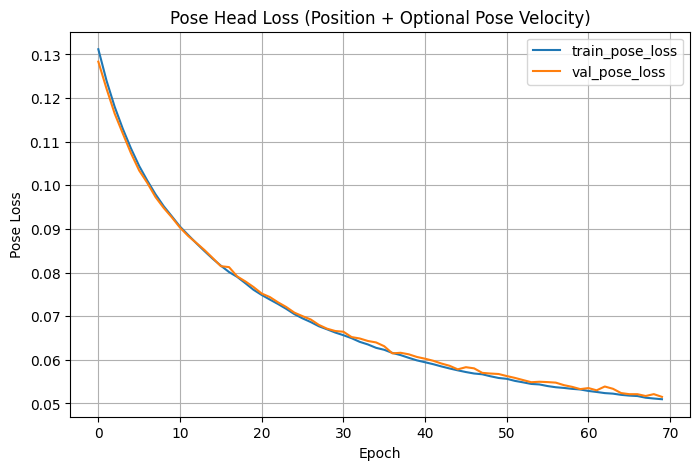

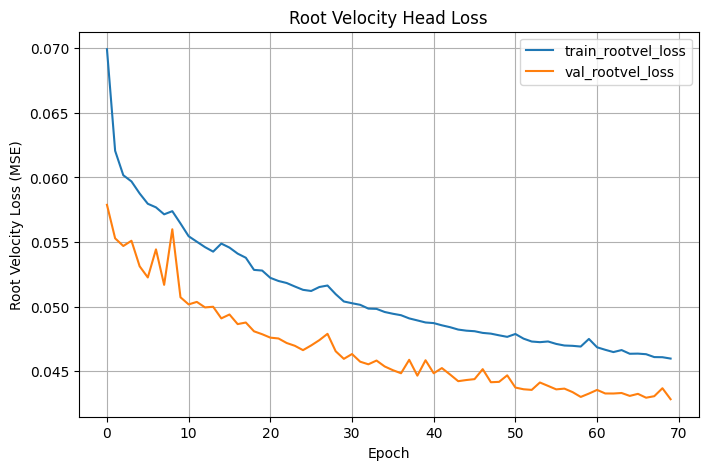

In [47]:
if not from_scratch:
    if os.path.exists(LOAD_MODEL_PATH):
        print(f"Loading model from: {LOAD_MODEL_PATH}")
        
        model = tf.keras.models.load_model(LOAD_MODEL_PATH,
            custom_objects={'pose_loss_with_vel': pose_loss_with_vel,},
            safe_mode=False
        )
    else:
         raise FileNotFoundError(f"Model file not found:\n{LOAD_MODEL_PATH}")
else:
    print("Training from scratch")

tf.config.run_functions_eagerly(False)  # for performance

history = model.fit(
    [X_train,decoder_input_train],
    [Y_pose_train, Y_root_train],
    validation_data=([X_test, decoder_input_test], [Y_pose_test, Y_root_test]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=callbacks_list,
    verbose=1
)

# ----------------------------
# 1) Combined Loss plot
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_total_loss')
plt.plot(history.history['val_loss'], label='val_total_loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Training / Validation Loss (Pose + RootVel)')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 2) Pose-only loss plot
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['pose_out_loss'], label='train_pose_loss')
plt.plot(history.history['val_pose_out_loss'], label='val_pose_loss')
plt.xlabel('Epoch')
plt.ylabel('Pose Loss')
plt.title('Pose Head Loss (Position + Optional Pose Velocity)')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 3) Root-velocity-only loss plot
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['rootvel_out_loss'], label='train_rootvel_loss')
plt.plot(history.history['val_rootvel_out_loss'], label='val_rootvel_loss')
plt.xlabel('Epoch')
plt.ylabel('Root Velocity Loss (MSE)')
plt.title('Root Velocity Head Loss')
plt.legend()
plt.grid(True)
plt.show()


### Choosing Model for Inferance

In [48]:
if from_scratch:
    print("Using model already in memory (just trained).")
else:
    print(f"\nLoading model from file:\n{LOAD_MODEL_PATH}\n")

    if not os.path.exists(LOAD_MODEL_PATH):
        raise FileNotFoundError(f"Model file not found:\n{LOAD_MODEL_PATH}")

    model = tf.keras.models.load_model(LOAD_MODEL_PATH,
        custom_objects={
            'pose_loss_with_vel': pose_loss_with_vel,
        },
        safe_mode=False
    )

    print("Model loaded successfully for inference.")


Loading model from file:
/Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_RNN_autoregressive_2head_20251127-215757.keras

Model loaded successfully for inference.


### Run Example

In [49]:
sample_idx = 0   # pick any index from test set

motion_id = ids_test[sample_idx]
print("Test motion ID:", motion_id)

# Input embedding (1, CAP_DIM)
z = X_test[sample_idx:sample_idx+1].astype(np.float32)

# ------------------------------------------------------------------
# 1) Autoregressive generation of motion from text embedding
# ------------------------------------------------------------------
pose_pred_norm, root_pred_norm = generate_motion_autoregressive(
    model,
    z_text=z,
    motion_len=MOTION_LEN,
    num_joints=NUM_JOINTS,
    coords=COORDS,
    verbose=False
)

print("  pose_pred_norm shape:", pose_pred_norm.shape)   # (T,J,3)
print("  root_pred_norm shape:", root_pred_norm.shape)   # (T,3)]

# ------------------------------------------------------------------
# 2) (De)normalize predicted pose & root velocity
# ------------------------------------------------------------------
if USE_NORMALIZATION:
    # pose_mean, pose_std, rootvel_mean, rootvel_std are already loaded
    # from NORM_STATS earlier in the notebook.
    pred_pose_rel = pose_pred_norm * pose_std + pose_mean      # (T,J,3)
    pred_root_vel = root_pred_norm * rootvel_std + rootvel_mean  # (T,3)
else:
    # Model outputs are already in the same space as training (root-relative)
    pred_pose_rel = pose_pred_norm
    pred_root_vel = root_pred_norm

# Remove batch dimension -> (T,J,3) and (T,3)
if pred_pose_rel.ndim == 4:
    pred_pose_rel = np.squeeze(pred_pose_rel, axis=0)
if pred_root_vel.ndim == 3:
    pred_root_vel = np.squeeze(pred_root_vel, axis=0)


print("After (de)normalization:")
print("  pred_pose_rel shape:", pred_pose_rel.shape)
print("  pred_root_vel shape:", pred_root_vel.shape)

# ------------------------------------------------------------------
# 3) Reconstruct full world motion using root velocity
# ------------------------------------------------------------------
# Integrate root velocity to get root trajectory
root_pred = np.zeros_like(pred_root_vel, dtype=np.float32)  # (T,3)
for t in range(1, MOTION_LEN):
    root_pred[t] = root_pred[t - 1] + pred_root_vel[t]

# Expand root trajectory to all joints and add to root-relative pose
root_pred_expanded = root_pred[:, None, :]              # (T,1,3)
pred_world = pred_pose_rel + root_pred_expanded         # (T,22,3)

print("Predicted motion (world coords) shape:", pred_world.shape)

# ------------------------------------------------------------------
# 4) Ground-truth motion (padded) for comparison
# ------------------------------------------------------------------
gt_motion_raw = motions_test[sample_idx]  # object array (T*,22,3)
gt_motion_fixed = pad_or_truncate_motion(gt_motion_raw, MOTION_LEN)
print("GT motion shape:", gt_motion_fixed.shape)

# For animation and downstream analysis, we will treat:
pred_real = pred_world.astype(np.float32)

Test motion ID: 012698
  pose_pred_norm shape: (1, 200, 22, 3)
  root_pred_norm shape: (1, 200, 3)
After (de)normalization:
  pred_pose_rel shape: (200, 22, 3)
  pred_root_vel shape: (200, 3)
Predicted motion (world coords) shape: (200, 22, 3)
GT motion shape: (200, 22, 3)


### Animation of Generated Motion

In [50]:
# SMPL 22-joint skeleton edges
edges = [
    (0, 1), (1, 4), (4, 7), (7, 10),
    (0, 2), (2, 5), (5, 8), (8, 11),
    (0, 3), (3, 6), (6, 9), (9, 12), (12, 15),
    (9, 13), (13, 16), (16, 18), (18, 20),
    (9, 14), (14, 17), (17, 19), (19, 21),
]

def save_motion_animation(motion, label, motion_id, base_dir):
    """
    motion: (T, 22, 3)
    label:  'generated' or 'gt'
    """
    pose = copy.deepcopy(motion)  # (T,22,3)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # FIXED AXIS LIMITS 
    ax.set(xlim3d=(-1, 3), xlabel='X')
    ax.set(ylim3d=(-1, 1), ylabel='Y')
    ax.set(zlim3d=(-1, 1), zlabel='Z')


    # Auto axis limits from motion
    #coords = pose.reshape(-1, 3)
    #x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
    #y_min, y_max = coords[:, 1].min(), coords[:, 1].max()
    #z_min, z_max = coords[:, 2].min(), coords[:, 2].max()
    #margin = 0.1

    #ax.set_xlim(x_min - margin, x_max + margin)
    #ax.set_ylim(y_min - margin, y_max + margin)
    #ax.set_zlim(z_min - margin, z_max + margin)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Create one line per edge
    lines = [ax.plot([], [], [])[0] for _ in edges]

    def update_lines(frame_num, pose, lines):
        frame = pose[frame_num]
        for n, (i, j) in enumerate(edges):
            x = [frame[i, 0], frame[j, 0]]
            y = [frame[i, 1], frame[j, 1]]
            z = [frame[i, 2], frame[j, 2]]
            # Keep your preferred orientation:
            lines[n].set_data_3d([z, x, y])
        return lines

    ani = FuncAnimation(
        fig,
        update_lines,
        frames=pose.shape[0],
        fargs=(pose, lines),
        interval=100
    )

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = f"{base_dir}/{label}_{motion_id}_{timestamp}.mp4"
    ani.save(save_path, writer='ffmpeg', fps=30)
    print(f"Saved {label} animation to:", save_path)
    plt.close(fig)


# save directory
anim_dir = "/Users/akhidre/pubgit/CS230_T2Motion/animations"

# Save predicted motion
save_motion_animation(pred_real, "generated_auto_regressive_2heads", motion_id, anim_dir)

# Save GT motion
save_motion_animation(gt_motion_fixed, "gt_fixed", motion_id, anim_dir)

Saved generated_auto_regressive_2heads animation to: /Users/akhidre/pubgit/CS230_T2Motion/animations/generated_auto_regressive_2heads_012698_20251128_111849.mp4
Saved gt_fixed animation to: /Users/akhidre/pubgit/CS230_T2Motion/animations/gt_fixed_012698_20251128_111857.mp4


### Troubleshoot/Debug

In [53]:
print("\n===== TROUBLESHOOTING START =====\n")

# 1) Ground-truth motion (world coordinates)
gt_motion_real = gt_motion_fixed.astype(np.float32)

# 2) Predicted world motion (from Run Example) 
pred_motion_real = pred_real.astype(np.float32)

print("GT motion shape:   ", gt_motion_real.shape)
print("Pred motion shape: ", pred_motion_real.shape)

# ------------------------------------------------------------
# 3) Per-frame statistics: center, min, max, scale
# ------------------------------------------------------------
def motion_frame_stats(name, motion, frame_idx):
    """motion: (T,22,3)"""
    f = motion[frame_idx]        # (22,3)
    min_xyz = f.min(axis=0)
    max_xyz = f.max(axis=0)
    center  = f.mean(axis=0)
    scale   = np.linalg.norm(f - center, axis=1).max()
    print(f"{name} frame {frame_idx:3d} | "
          f"center {center} | "
          f"min {min_xyz} | max {max_xyz} | scale {scale:.3f}")

print("\n===== Per-frame stats =====")
frames_to_check = [0, 1, 5, 10, 50, 100, 199]
for fi in frames_to_check:
    print(f"\n---- Frame {fi} ----")
    motion_frame_stats("GT  ",   gt_motion_real,   fi)
    motion_frame_stats("Pred", pred_motion_real, fi)


# ------------------------------------------------------------
# 4) Skeleton scale over time
# ------------------------------------------------------------
def skeleton_scale_over_time(motion):
    """
    motion: (T,22,3)
    Computes max distance between root joint and all other joints for each frame.
    """
    root = motion[:, 0, :]                                 # (T,3)
    dists = np.linalg.norm(motion - root[:, None, :], axis=2)  # (T,22)
    return dists.max(axis=1)                               # (T,)

gt_scale   = skeleton_scale_over_time(gt_motion_real)
pred_scale = skeleton_scale_over_time(pred_motion_real)

print("\n===== Scale stability check =====")

print("\nGT scales (first 10):")
print(gt_scale[:10])

print("\nPred scales (first 10):")
print(pred_scale[:10])

print("\nGT scales (last 10):")
print(gt_scale[-10:])

print("\nPred scales (last 10):")
print(pred_scale[-10:])

print(f"\nMean GT scale:   {gt_scale.mean():.4f}")
print(f"Mean Pred scale: {pred_scale.mean():.4f}")

print(f"\nGT scale range:   {gt_scale.min():.4f} → {gt_scale.max():.4f}")
print(f"Pred scale range: {pred_scale.min():.4f} → {pred_scale.max():.4f}")
print("\n===== TROUBLESHOOTING END =====\n")

# ------------------------------------------------------------
# 5) Root trajectory analysis
# ------------------------------------------------------------
print("\n===== Root trajectory analysis =====")

# Extract root joint (joint 0)
gt_root   = gt_motion_real[:, 0, :]      # (T,3)
pred_root = pred_motion_real[:, 0, :]    # (T,3)

# Compute per-frame displacement (speed)
gt_root_speed   = np.linalg.norm(gt_root[1:] - gt_root[:-1], axis=1)
pred_root_speed = np.linalg.norm(pred_root[1:] - pred_root[:-1], axis=1)

print("\nGT root trajectory (first 10 positions):")
print(gt_root[:10])
print("\nPred root trajectory (first 10 positions):")
print(pred_root[:10])

print("\nGT root trajectory (last 10 positions):")
print(gt_root[-10:])
print("\nPred root trajectory (last 10 positions):")
print(pred_root[-10:])

print("\nGT root speed (first 10):")
print(gt_root_speed[:10])
print("\nPred root speed (first 10):")
print(pred_root_speed[:10])

print("\nGT root speed (last 10):")
print(gt_root_speed[-10:])
print("\nPred root speed (last 10):")
print(pred_root_speed[-10:])

print("\nRoot position ranges:")
print("GT   root min:", gt_root.min(axis=0), "max:", gt_root.max(axis=0))
print("Pred root min:", pred_root.min(axis=0), "max:", pred_root.max(axis=0))

print(LAMBDA_VEL, LAMBDA_ROOT)



===== TROUBLESHOOTING START =====

GT motion shape:    (200, 22, 3)
Pred motion shape:  (200, 22, 3)

===== Per-frame stats =====

---- Frame 0 ----
GT   frame   0 | center [ 0.00454317  0.9342197  -0.02863133] | min [-0.58554494  0.00137683 -0.08900792] | max [0.58068657 1.5800942  0.04461181] | scale 0.951
Pred frame   0 | center [-0.00099417 -0.01426083  0.00827267] | min [-0.33864737 -0.9388718  -0.03203705] | max [0.33354634 0.61883074 0.09557296] | scale 0.946

---- Frame 1 ----
GT   frame   1 | center [ 0.00454311  0.93014437 -0.02827122] | min [-0.5630458   0.00132576 -0.08928806] | max [0.55653065 1.5804219  0.04436097] | scale 0.947
Pred frame   1 | center [-0.00019069 -0.01521031  0.00810291] | min [-0.33161   -0.9343981 -0.0305114] | max [0.33501118 0.6136041  0.09809596] | scale 0.940

---- Frame 5 ----
GT   frame   5 | center [ 0.00485054  0.91726214 -0.02788577] | min [-0.4605426   0.00129556 -0.09045201] | max [0.45074052 1.5810748  0.04369877] | scale 0.935
Pred frame